In [846]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [847]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [848]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397918 entries, 0 to 2397917
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.6 MB


# reduce to 1 million events

In [849]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [850]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,24084,0.15,24.084
1,23404,0.15,23.404
2,22852,0.16,22.852
3,22824,0.16,22.824
4,23568,0.15,23.568
...,...,...,...
999995,25994,0.14,25.994
999996,25745,0.14,25.745
999997,26533,0.14,26.533
999998,26513,0.14,26.513


### conversion Interval -> kWh

In [851]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,24084,0.15,24.084,149.476831
1,23404,0.15,23.404,153.819860
2,22852,0.16,22.852,157.535445
3,22824,0.16,22.824,157.728707
4,23568,0.15,23.568,152.749491
...,...,...,...,...
999995,25994,0.14,25.994,138.493498
999996,25745,0.14,25.745,139.832977
999997,26533,0.14,26.533,135.680096
999998,26513,0.14,26.513,135.782446


### Cumul Total interval

In [852]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [853]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27118952344000

### Calcul de la date de base = now - cumul_interval

In [854]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 5, 14, 40, 8, 571106)

In [855]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [856]:
conso_data.iloc[0]


Interval     24084.000000
kWh              0.150000
sec             24.084000
Wh             149.476831
cumul(ms)    24084.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [857]:
base

datetime.datetime(2024, 9, 5, 14, 40, 8, 571106)

## créer les dates

In [858]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-05 14:40:32.655106
1        2024-09-05 14:40:56.059106
2        2024-09-05 14:41:18.911106
3        2024-09-05 14:41:41.735106
4        2024-09-05 14:42:05.303106
                    ...            
999995   2025-07-16 11:40:56.105106
999996   2025-07-16 11:41:21.850106
999997   2025-07-16 11:41:48.383106
999998   2025-07-16 11:42:14.896106
999999   2025-07-16 11:42:40.915106
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [859]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,24084,0.15,24.084,149.476831,24084,2024-09-05 14:40:32.655106,05/09/24
1,23404,0.15,23.404,153.819860,47488,2024-09-05 14:40:56.059106,05/09/24
2,22852,0.16,22.852,157.535445,70340,2024-09-05 14:41:18.911106,05/09/24
3,22824,0.16,22.824,157.728707,93164,2024-09-05 14:41:41.735106,05/09/24
4,23568,0.15,23.568,152.749491,116732,2024-09-05 14:42:05.303106,05/09/24
...,...,...,...,...,...,...,...
999995,25994,0.14,25.994,138.493498,27118847534,2025-07-16 11:40:56.105106,16/07/25
999996,25745,0.14,25.745,139.832977,27118873279,2025-07-16 11:41:21.850106,16/07/25
999997,26533,0.14,26.533,135.680096,27118899812,2025-07-16 11:41:48.383106,16/07/25
999998,26513,0.14,26.513,135.782446,27118926325,2025-07-16 11:42:14.896106,16/07/25


### save conso_data with dates

In [860]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [861]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('16/07/25', 16, 7, 2025, '11:43:02')

In [862]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [863]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1433 entries, 998567 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1433 non-null   int64         
 1   kWh        1433 non-null   float64       
 2   sec        1433 non-null   float64       
 3   Wh         1433 non-null   float64       
 4   cumul(ms)  1433 non-null   int64         
 5   dates      1433 non-null   datetime64[ns]
 6   days       1433 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 89.6+ KB


In [864]:
end = time.time()
print(end - start)

29.200199842453003


### grouped by days

In [865]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [866]:
data = list(df_grp['kWh'])
print(data)

[1.422, 3.664, 3.604, 3.155, 2.617, 1.799, 1.792, 1.796, 1.794, 2.411, 1.926, 1.788, 1.793, 1.787, 1.82, 1.819, 1.818, 1.815, 1.818, 1.816, 1.815, 1.819, 1.784, 1.788, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.793, 1.801, 1.798, 1.798, 1.801, 1.786, 1.787, 1.787, 1.789, 1.797, 1.792, 1.799, 1.804, 1.793, 1.802, 1.798, 2.64, 3.999, 3.68, 3.896, 3.092, 3.347, 4.141, 3.352, 3.515, 3.987, 3.323, 3.732, 3.572, 3.978, 3.204, 3.315, 3.391, 4.094, 3.287, 3.392, 3.815, 3.23, 3.542, 3.292, 3.914, 3.355, 3.418, 3.754, 4.409, 3.601, 3.857, 3.371, 4.225, 3.496, 3.448, 3.283, 3.86, 3.687, 4.117, 3.213, 3.727, 3.809, 3.155, 3.685, 3.65, 3.389, 3.882, 3.19, 4.062, 3.451, 3.699, 4.077, 3.405, 4.536, 3.265, 3.458, 3.116, 3.221, 3.427, 3.351, 3.423, 3.424, 4.6, 4.551, 3.226, 3.452, 3.638, 3.927, 3.548, 4.459, 4.178, 4.084, 3.782, 3.726, 3.56, 3.537, 4.387, 3.164, 3.381, 3.401, 3.449, 3.611, 3.376, 4.552, 3.263, 3.787, 3.248, 3.601, 3.545, 3.289, 3.99, 3.282, 4.673, 3.939, 3.312, 4.433, 3.509, 4.7

In [867]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [868]:
end = time.time()
print(end - start)

30.11673092842102


### plot function by day
#### show('dd/mm/yy')

In [869]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


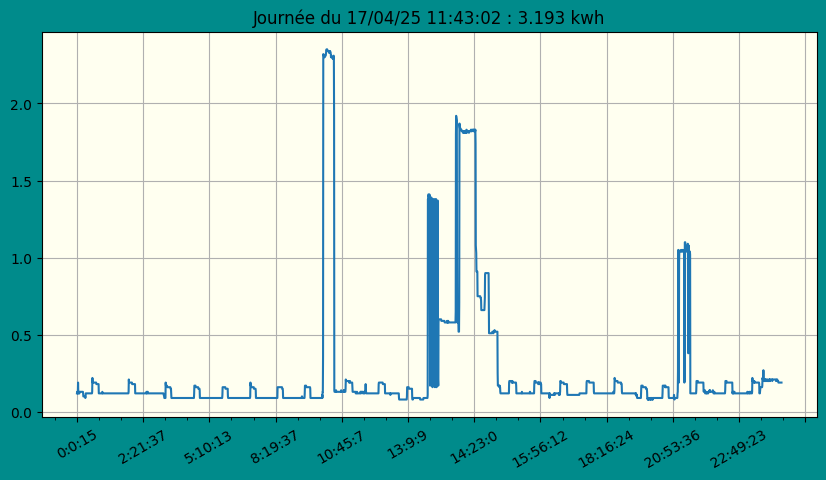

In [870]:
show('17/04/25')

In [871]:
end = time.time()
print(end - start)

31.88389015197754


### 1 kWh window in data of one day
#### df = conso_day

In [872]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998567,37364,0.10,37.364,96.349427,27076798362,2025-07-16 00:00:06.933106,16/07/25
998568,36761,0.10,36.761,97.929871,27076835123,2025-07-16 00:00:43.694106,16/07/25
998569,34680,0.10,34.680,103.806228,27076869803,2025-07-16 00:01:18.374106,16/07/25
998570,35581,0.10,35.581,101.177595,27076905384,2025-07-16 00:01:53.955106,16/07/25
998571,17936,0.20,17.936,200.713649,27076923320,2025-07-16 00:02:11.891106,16/07/25
...,...,...,...,...,...,...,...
999995,25994,0.14,25.994,138.493498,27118847534,2025-07-16 11:40:56.105106,16/07/25
999996,25745,0.14,25.745,139.832977,27118873279,2025-07-16 11:41:21.850106,16/07/25
999997,26533,0.14,26.533,135.680096,27118899812,2025-07-16 11:41:48.383106,16/07/25
999998,26513,0.14,26.513,135.782446,27118926325,2025-07-16 11:42:14.896106,16/07/25


In [873]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [874]:
df = conso_day
len(df)

1433

In [875]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-16 00:00:06.933106	2025-07-16 08:38:22.946106	8h 38m 16s 	1000
2025-07-16 08:38:22.946106	2025-07-16 11:42:40.915106	3h 4m 17s 	433


In [876]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301297
dtype: float64

In [877]:
end = time.time()
print(end - start)

32.29407572746277


## mean for data grouped by days

In [878]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.174603
dtype: float64

In [879]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.433)

# conso by date


In [880]:
# select day
day = today

#day = '16/08/24'
day

'16/07/25'

In [881]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998567,37364,0.10,37.364,96.349427,27076798362,2025-07-16 00:00:06.933106,16/07/25
998568,36761,0.10,36.761,97.929871,27076835123,2025-07-16 00:00:43.694106,16/07/25
998569,34680,0.10,34.680,103.806228,27076869803,2025-07-16 00:01:18.374106,16/07/25
998570,35581,0.10,35.581,101.177595,27076905384,2025-07-16 00:01:53.955106,16/07/25
998571,17936,0.20,17.936,200.713649,27076923320,2025-07-16 00:02:11.891106,16/07/25
...,...,...,...,...,...,...,...
999995,25994,0.14,25.994,138.493498,27118847534,2025-07-16 11:40:56.105106,16/07/25
999996,25745,0.14,25.745,139.832977,27118873279,2025-07-16 11:41:21.850106,16/07/25
999997,26533,0.14,26.533,135.680096,27118899812,2025-07-16 11:41:48.383106,16/07/25
999998,26513,0.14,26.513,135.782446,27118926325,2025-07-16 11:42:14.896106,16/07/25


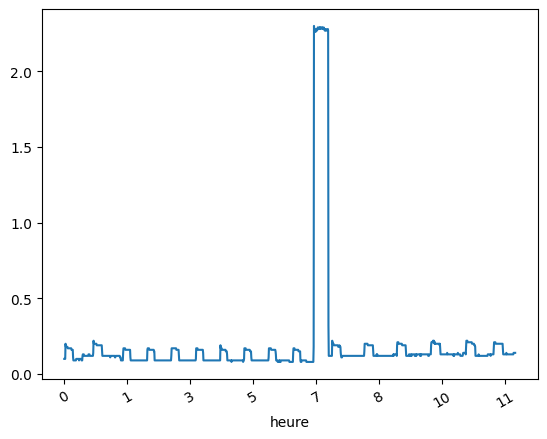

In [882]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [883]:
end = time.time()
print(end - start)

33.21349573135376


### grouped by 'heure'

In [884]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1433 entries, 998567 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1433 non-null   int64         
 1   kWh        1433 non-null   float64       
 2   sec        1433 non-null   float64       
 3   Wh         1433 non-null   float64       
 4   cumul(ms)  1433 non-null   int64         
 5   dates      1433 non-null   datetime64[ns]
 6   days       1433 non-null   object        
 7   heure      1433 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 100.8+ KB


In [885]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998567,37364,0.10,37.364,96.349427,27076798362,2025-07-16 00:00:06.933106,16/07/25
998568,36761,0.10,36.761,97.929871,27076835123,2025-07-16 00:00:43.694106,16/07/25
998569,34680,0.10,34.680,103.806228,27076869803,2025-07-16 00:01:18.374106,16/07/25
998570,35581,0.10,35.581,101.177595,27076905384,2025-07-16 00:01:53.955106,16/07/25
998571,17936,0.20,17.936,200.713649,27076923320,2025-07-16 00:02:11.891106,16/07/25
...,...,...,...,...,...,...,...
999995,25994,0.14,25.994,138.493498,27118847534,2025-07-16 11:40:56.105106,16/07/25
999996,25745,0.14,25.745,139.832977,27118873279,2025-07-16 11:41:21.850106,16/07/25
999997,26533,0.14,26.533,135.680096,27118899812,2025-07-16 11:41:48.383106,16/07/25
999998,26513,0.14,26.513,135.782446,27118926325,2025-07-16 11:42:14.896106,16/07/25


In [886]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [887]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     131
1     111
2      99
3     109
4      98
5      97
6     108
7     158
8     131
9     146
10    142
11    103
Name: kWh, dtype: int64

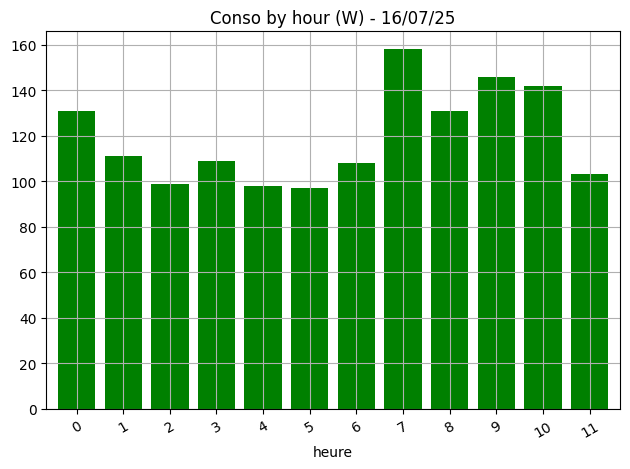

In [888]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [889]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 05/09/24 to 16/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     315 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [890]:
# give the periods of 1 kwh in a day
period()

2025-07-16 00:00:06.933106	2025-07-16 08:38:22.946106	8h 38m 16s 	1000


In [891]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [892]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [893]:
df_grp.mean()


kWh    3.174603
dtype: float64

In [894]:
df_grp.head()


,kWh
days,
05/09/24,1.422
06/09/24,3.664
07/09/24,3.604
08/09/24,3.155
09/09/24,2.617


In [895]:
df_grp.tail()


,kWh
days,
12/07/25,2.603
13/07/25,2.714
14/07/25,3.270
15/07/25,3.551
16/07/25,1.433


In [896]:
end = time.time()
print(end - start)

34.64239430427551


# plot les 100 derniers jours


In [897]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    2.99376
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

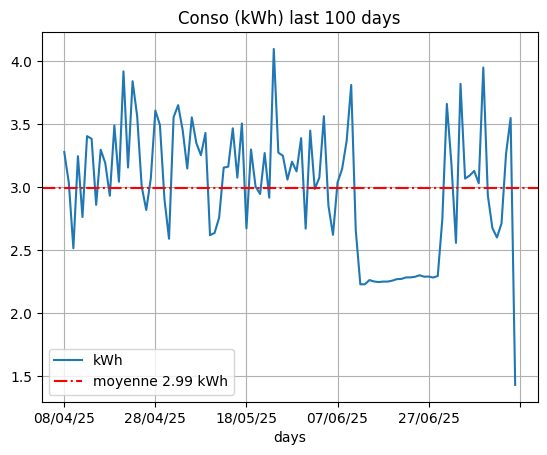

In [898]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [899]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.433
max,4.099


In [900]:
end = time.time()
print(end - start)

35.91038537025452


In [901]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('16/06/25', '11/07/25')

In [902]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.730033
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

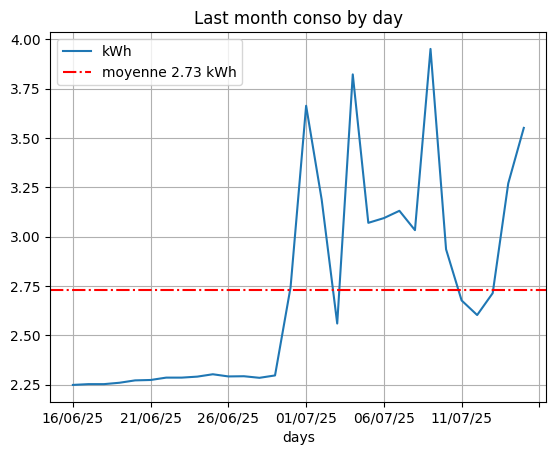

In [903]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [904]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/07/25 3.951
Min : 16/06/25 2.249


# Temps de conso par tranche de 1 kWh

In [905]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-07-16 00:00:06.933106	2025-07-16 08:38:22.946106	8h 38m 16s 	1000
2025-07-16 08:38:22.946106	2025-07-16 11:42:40.915106	3h 4m 17s 	433


In [906]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('11:43:02', 1.433, 1433)

In [907]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1433 entries, 998567 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1433 non-null   int64         
 1   kWh        1433 non-null   float64       
 2   sec        1433 non-null   float64       
 3   Wh         1433 non-null   float64       
 4   cumul(ms)  1433 non-null   int64         
 5   dates      1433 non-null   datetime64[ns]
 6   days       1433 non-null   object        
 7   heure      1433 non-null   object        
 8   hours      1433 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 112.0+ KB


In [908]:
conso_hours['heure'], conso_hours['hours']

(998567     0
 998568     0
 998569     0
 998570     0
 998571     0
           ..
 999995    11
 999996    11
 999997    11
 999998    11
 999999    11
 Name: heure, Length: 1433, dtype: object,
 998567    00
 998568    00
 998569    00
 998570    00
 998571    00
           ..
 999995    11
 999996    11
 999997    11
 999998    11
 999999    11
 Name: hours, Length: 1433, dtype: object)

In [909]:
end = time.time()
print(end - start)

37.622841358184814


# select number of days to display


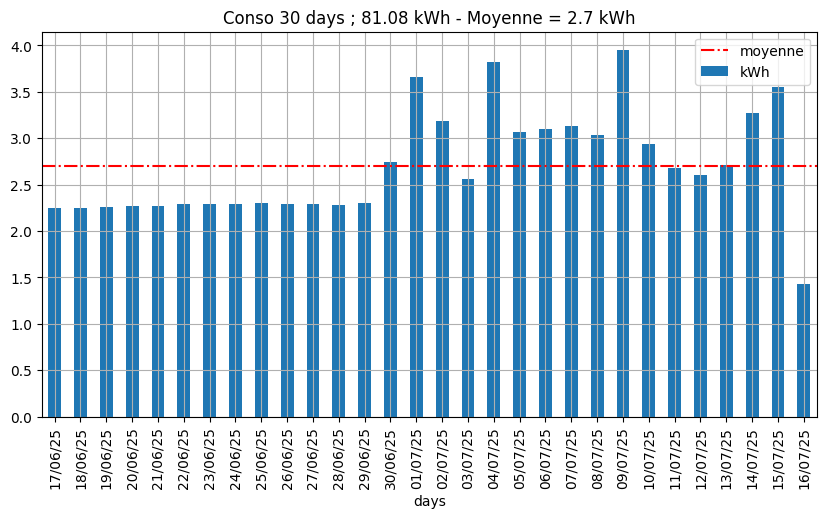

In [910]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


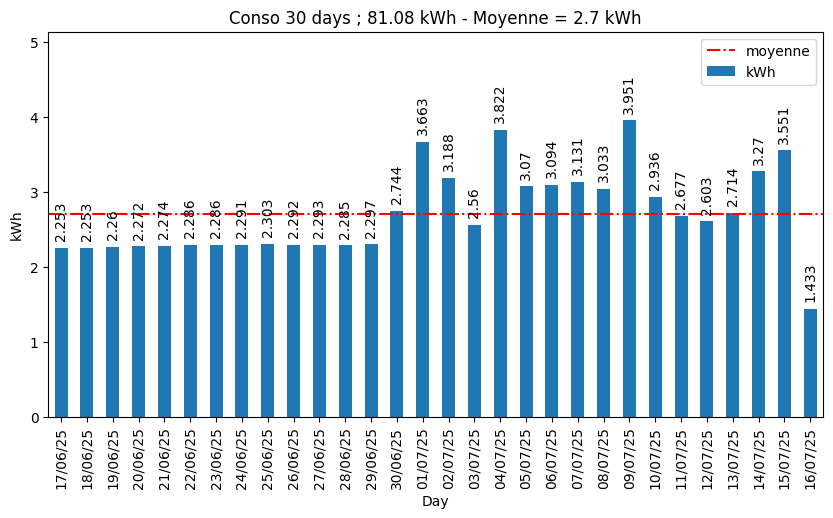

In [911]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [912]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
17/06/25    2.253
18/06/25    2.253
19/06/25    2.260
20/06/25    2.272
21/06/25    2.274
22/06/25    2.286
23/06/25    2.286
24/06/25    2.291
25/06/25    2.303
26/06/25    2.292
27/06/25    2.293
28/06/25    2.285
29/06/25    2.297
30/06/25    2.744
01/07/25    3.663
02/07/25    3.188
03/07/25    2.560
04/07/25    3.822
05/07/25    3.070
06/07/25    3.094
07/07/25    3.131
08/07/25    3.033
09/07/25    3.951
10/07/25    2.936
11/07/25    2.677
12/07/25    2.603
13/07/25    2.714
14/07/25    3.270
15/07/25    3.551
16/07/25    1.433
Name: kWh, dtype: float64

In [913]:
x_labels=df_grp.tail(span).index
x_labels

Index(['17/06/25', '18/06/25', '19/06/25', '20/06/25', '21/06/25', '22/06/25',
       '23/06/25', '24/06/25', '25/06/25', '26/06/25', '27/06/25', '28/06/25',
       '29/06/25', '30/06/25', '01/07/25', '02/07/25', '03/07/25', '04/07/25',
       '05/07/25', '06/07/25', '07/07/25', '08/07/25', '09/07/25', '10/07/25',
       '11/07/25', '12/07/25', '13/07/25', '14/07/25', '15/07/25', '16/07/25'],
      dtype='object', name='days')

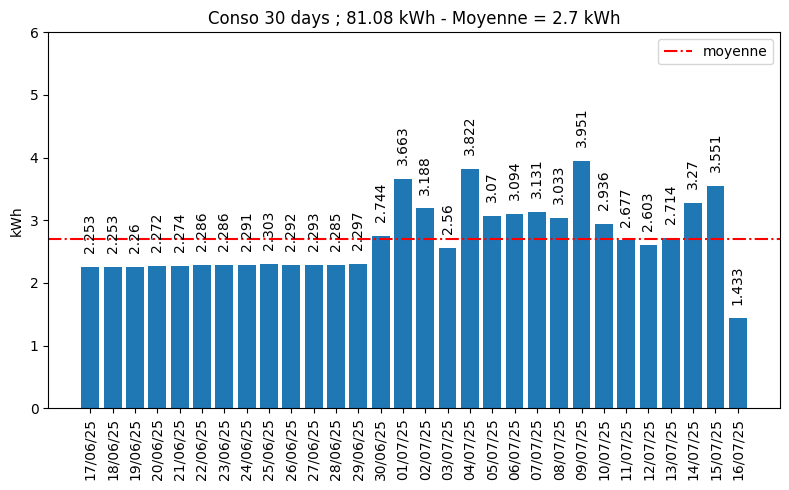

In [914]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [915]:
end = time.time()
print(end - start)

42.75065279006958


In [916]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

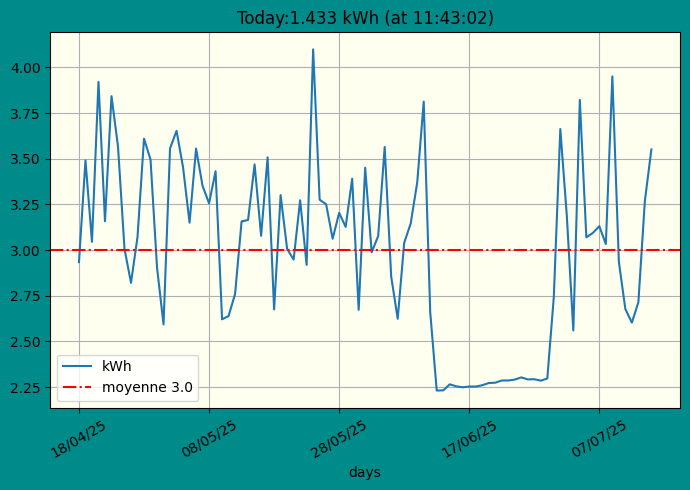

In [917]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

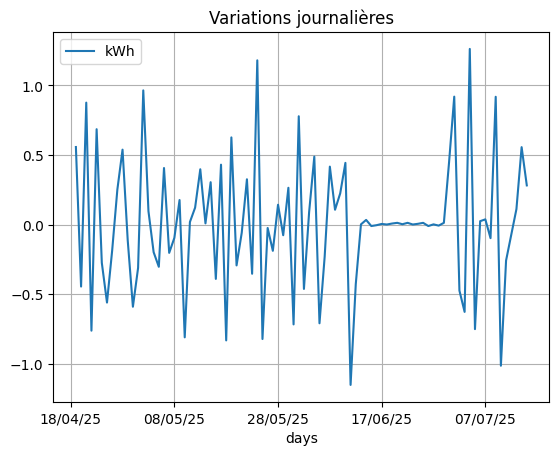

In [918]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [919]:
end = time.time()
print(end - start)

43.83175730705261


# Data from 21/08/23

In [920]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,24084,0.15,24.084,149.476831,24084,2024-09-05 14:40:32.655106,05/09/24,14,2024-09,05
1,23404,0.15,23.404,153.819860,47488,2024-09-05 14:40:56.059106,05/09/24,14,2024-09,05
2,22852,0.16,22.852,157.535445,70340,2024-09-05 14:41:18.911106,05/09/24,14,2024-09,05
3,22824,0.16,22.824,157.728707,93164,2024-09-05 14:41:41.735106,05/09/24,14,2024-09,05
4,23568,0.15,23.568,152.749491,116732,2024-09-05 14:42:05.303106,05/09/24,14,2024-09,05
...,...,...,...,...,...,...,...,...,...,...
999995,25994,0.14,25.994,138.493498,27118847534,2025-07-16 11:40:56.105106,16/07/25,11,2025-07,16
999996,25745,0.14,25.745,139.832977,27118873279,2025-07-16 11:41:21.850106,16/07/25,11,2025-07,16
999997,26533,0.14,26.533,135.680096,27118899812,2025-07-16 11:41:48.383106,16/07/25,11,2025-07,16
999998,26513,0.14,26.513,135.782446,27118926325,2025-07-16 11:42:14.896106,16/07/25,11,2025-07,16


In [921]:
end = time.time()
print(end - start)

86.05487489700317


In [922]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

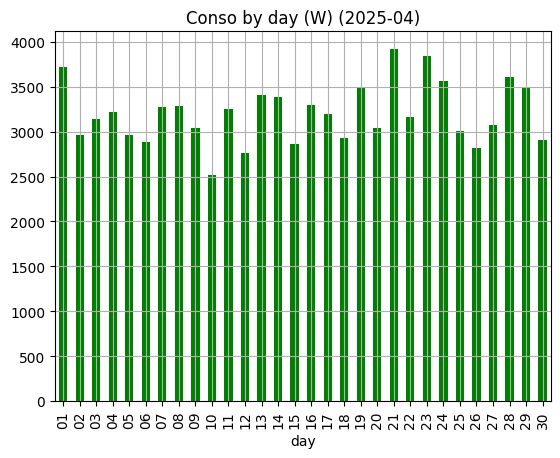

In [923]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [924]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.366666666667)

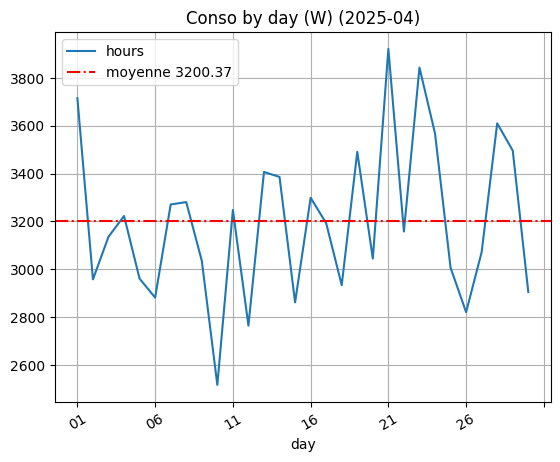

In [925]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [926]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

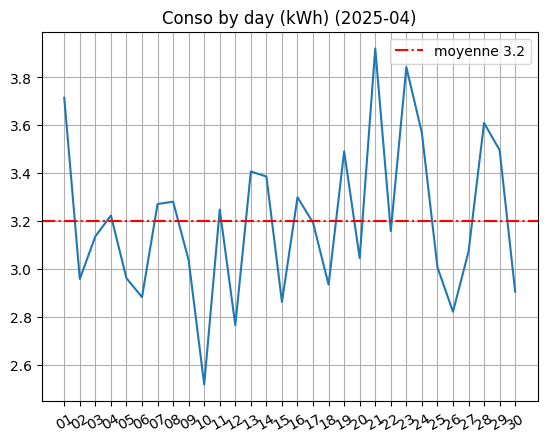

In [927]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [928]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [929]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [930]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,53029,53029,53029
2024-10,73318,73318,73318
2024-11,108175,108175,108175
2024-12,113981,113981,113981
2025-01,113880,113880,113880
2025-02,104275,104275,104275
2025-03,111820,111820,111820
2025-04,96011,96011,96011
2025-05,98606,98606,98606


In [931]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [932]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [933]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
05/09/24,1422
06/09/24,3664
07/09/24,3604
08/09/24,3155
09/09/24,2617
...,...
12/07/25,2603
13/07/25,2714
14/07/25,3270


In [934]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,24084,0.15,24.084,149.476831,24084,2024-09-05 14:40:32.655106,05/09/24,14,2024-09,05
1,23404,0.15,23.404,153.819860,47488,2024-09-05 14:40:56.059106,05/09/24,14,2024-09,05
2,22852,0.16,22.852,157.535445,70340,2024-09-05 14:41:18.911106,05/09/24,14,2024-09,05
3,22824,0.16,22.824,157.728707,93164,2024-09-05 14:41:41.735106,05/09/24,14,2024-09,05
4,23568,0.15,23.568,152.749491,116732,2024-09-05 14:42:05.303106,05/09/24,14,2024-09,05
...,...,...,...,...,...,...,...,...,...,...
999995,25994,0.14,25.994,138.493498,27118847534,2025-07-16 11:40:56.105106,16/07/25,11,2025-07,16
999996,25745,0.14,25.745,139.832977,27118873279,2025-07-16 11:41:21.850106,16/07/25,11,2025-07,16
999997,26533,0.14,26.533,135.680096,27118899812,2025-07-16 11:41:48.383106,16/07/25,11,2025-07,16
999998,26513,0.14,26.513,135.782446,27118926325,2025-07-16 11:42:14.896106,16/07/25,11,2025-07,16


In [935]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
05/09/24 14    0       05/09/24    14  0.15
               1       05/09/24    14  0.15
               2       05/09/24    14  0.16
               3       05/09/24    14  0.16
               4       05/09/24    14  0.15
...                         ...   ...   ...
16/07/25 11    999995  16/07/25    11  0.14
               999996  16/07/25    11  0.14
               999997  16/07/25    11  0.14
               999998  16/07/25    11  0.14
               999999  16/07/25    11  0.14

[1000000 rows x 3 columns]

In [936]:
groupallbyday.indices.keys()

dict_keys(['05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/11/24', '25/11/24', '26/1

In [937]:
groupallbydayhours.indices.keys()

dict_keys([('05/09/24', '14'), ('05/09/24', '15'), ('05/09/24', '16'), ('05/09/24', '17'), ('05/09/24', '18'), ('05/09/24', '19'), ('05/09/24', '20'), ('05/09/24', '21'), ('05/09/24', '22'), ('05/09/24', '23'), ('06/09/24', '14'), ('06/09/24', '15'), ('06/09/24', '16'), ('06/09/24', '17'), ('06/09/24', '18'), ('06/09/24', '19'), ('06/09/24', '20'), ('06/09/24', '21'), ('06/09/24', '22'), ('06/09/24', '23'), ('06/09/24', '00'), ('06/09/24', '01'), ('06/09/24', '02'), ('06/09/24', '03'), ('06/09/24', '04'), ('06/09/24', '05'), ('06/09/24', '06'), ('06/09/24', '07'), ('06/09/24', '08'), ('06/09/24', '09'), ('06/09/24', '10'), ('06/09/24', '11'), ('06/09/24', '12'), ('06/09/24', '13'), ('07/09/24', '14'), ('07/09/24', '15'), ('07/09/24', '16'), ('07/09/24', '17'), ('07/09/24', '18'), ('07/09/24', '19'), ('07/09/24', '20'), ('07/09/24', '21'), ('07/09/24', '22'), ('07/09/24', '23'), ('07/09/24', '00'), ('07/09/24', '01'), ('07/09/24', '02'), ('07/09/24', '03'), ('07/09/24', '04'), ('07/09/2

In [938]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
05/09/24,1422,1422
06/09/24,3664,3664
07/09/24,3604,3604
08/09/24,3155,3155
09/09/24,2617,2617
...,...,...
12/07/25,2603,2603
13/07/25,2714,2714
14/07/25,3270,3270


In [939]:
grp_by_day['kWh'].cumsum()

days
05/09/24       1422
06/09/24       5086
07/09/24       8690
08/09/24      11845
09/09/24      14462
             ...   
12/07/25     989032
13/07/25     991746
14/07/25     995016
15/07/25     998567
16/07/25    1000000
Name: kWh, Length: 315, dtype: int64

In [940]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
05/09/24 14      50
         15     162
         16     157
         17     215
         18     161
...             ...
16/07/25 07     158
         08     131
         09     146
         10     142
         11     103

[7534 rows x 1 columns]

In [941]:
grp_by_dayhours['kWh'].cumsum()

days      hours
05/09/24  14            50
          15           212
          16           369
          17           584
          18           745
                    ...   
16/07/25  07        999478
          08        999609
          09        999755
          10        999897
          11       1000000
Name: kWh, Length: 7534, dtype: int64

In [942]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
05/09/24 14      50      50    NaN
         15     162     212  112.0
         16     157     369   -5.0
         17     215     584   58.0
         18     161     745  -54.0
...             ...     ...    ...
16/07/25 07     158     911   50.0
         08     131    1042  -27.0
         09     146    1188   15.0
         10     142    1330   -4.0
         11     103    1433  -39.0

[7534 rows x 3 columns]

In [943]:
today, grp_by_dayhours.loc[today]

('16/07/25',
        kWh  cumsum  diff
 hours                   
 00     131     131   NaN
 01     111     242 -20.0
 02      99     341 -12.0
 03     109     450  10.0
 04      98     548 -11.0
 05      97     645  -1.0
 06     108     753  11.0
 07     158     911  50.0
 08     131    1042 -27.0
 09     146    1188  15.0
 10     142    1330  -4.0
 11     103    1433 -39.0)

Text(0.5, 1.0, 'Cumul journalier')

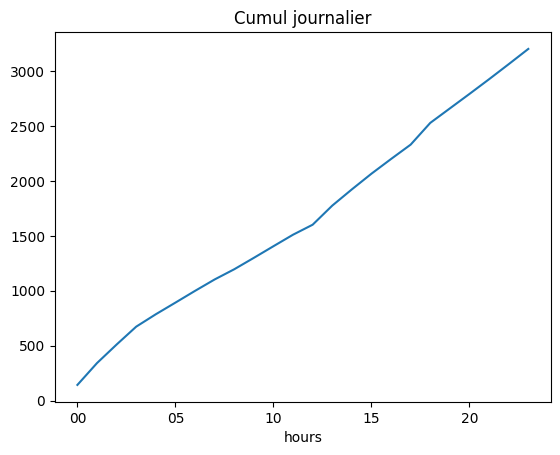

In [944]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

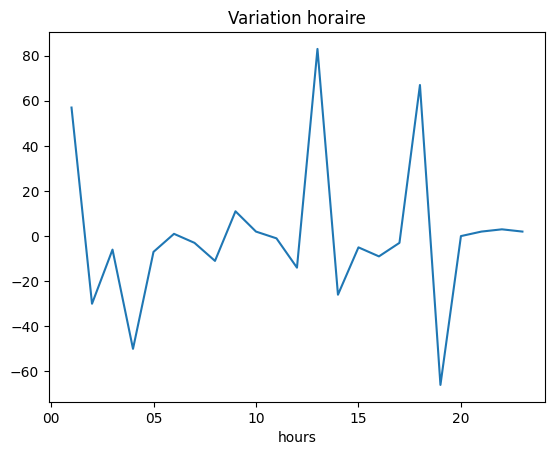

In [945]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [946]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

315

In [947]:
df_grp.tail(n)['kWh'].describe()


count    315.000000
mean       3.174603
std        0.742119
min        1.422000
25%        2.793000
50%        3.312000
75%        3.658000
max        4.787000
Name: kWh, dtype: float64

In [948]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [949]:
n, np.nanmean(df_grp.tail(n))

(315, np.float64(3.1746031746031744))

Text(0.5, 1.0, '315 days')

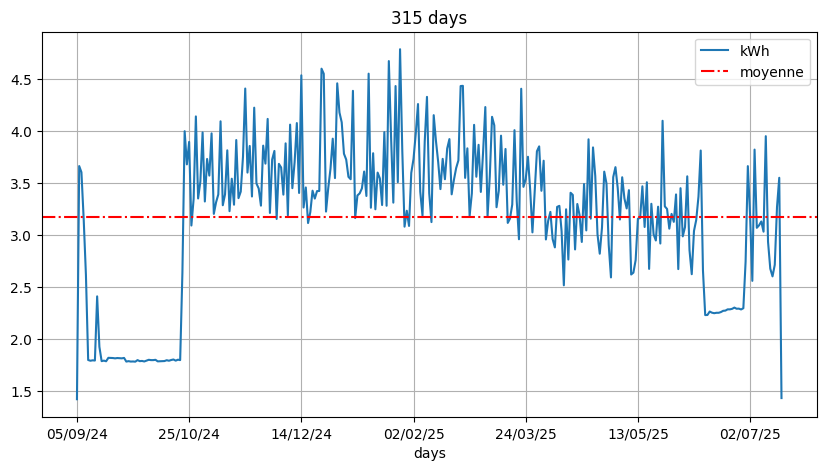

In [950]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

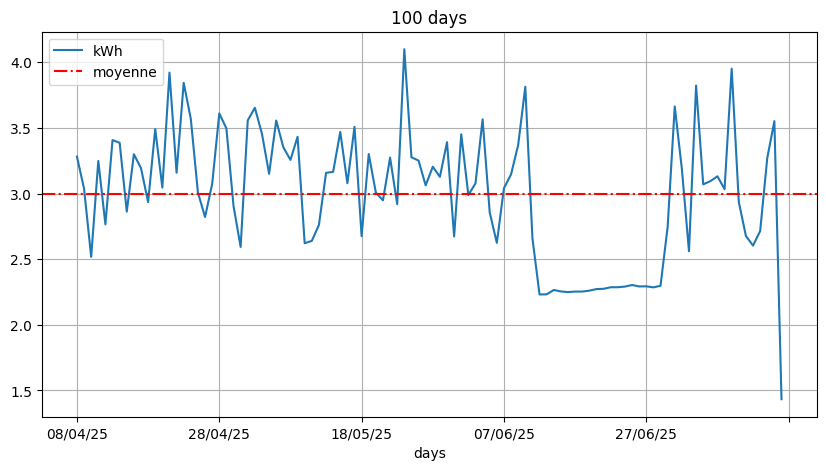

In [951]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [952]:
np.nanmean(df_grp.tail(span))

np.float64(2.99376)

In [953]:
df_grp['kWh']

days
05/09/24    1.422
06/09/24    3.664
07/09/24    3.604
08/09/24    3.155
09/09/24    2.617
            ...  
12/07/25    2.603
13/07/25    2.714
14/07/25    3.270
15/07/25    3.551
16/07/25    1.433
Name: kWh, Length: 315, dtype: float64

In [954]:
df_grp.describe()

,kWh
count,315.000000
mean,3.174603
std,0.742119
min,1.422000
25%,2.793000
50%,3.312000
75%,3.658000
max,4.787000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

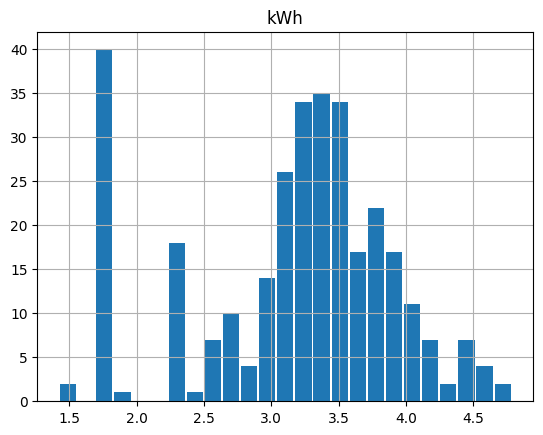

In [955]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [956]:
df_grp.tail(span)['kWh']

days
08/04/25    3.281
09/04/25    3.036
10/04/25    2.517
11/04/25    3.248
12/04/25    2.765
            ...  
12/07/25    2.603
13/07/25    2.714
14/07/25    3.270
15/07/25    3.551
16/07/25    1.433
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [957]:
day

'16/07/25'

In [958]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,131,131,NaN
01,111,242,-20.0
02,99,341,-12.0
03,109,450,10.0
04,98,548,-11.0
05,97,645,-1.0
06,108,753,11.0
07,158,911,50.0
08,131,1042,-27.0


In [959]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


12

In [960]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 13)

In [961]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [962]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [963]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [964]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [965]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 00 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     12 non-null     int64  
 1   cumsum  12 non-null     int64  
 2   diff    11 non-null     float64
 3   days    12 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 480.0+ bytes


In [966]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [967]:
day

'16/07/25'

In [968]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,131,131,NaN,1.0
01,111,242,-20.0,2.0
02,99,341,-12.0,3.0
03,109,450,10.0,4.0
04,98,548,-11.0,5.0
05,97,645,-1.0,6.0
06,108,753,11.0,7.0
07,158,911,50.0,8.0
08,131,1042,-27.0,9.0


In [969]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_3340\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.4329999999999998)

In [970]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
05/09/24 14      50      50    NaN   NaN
         15     162     212  112.0   NaN
         16     157     369   -5.0   NaN
         17     215     584   58.0   NaN
         18     161     745  -54.0   NaN
...             ...     ...    ...   ...
16/07/25 07     158     911   50.0   8.0
         08     131    1042  -27.0   9.0
         09     146    1188   15.0  10.0
         10     142    1330   -4.0  11.0
         11     103    1433  -39.0  12.0

[7534 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '16/07/25: kWh    1.433\ndtype: float64')

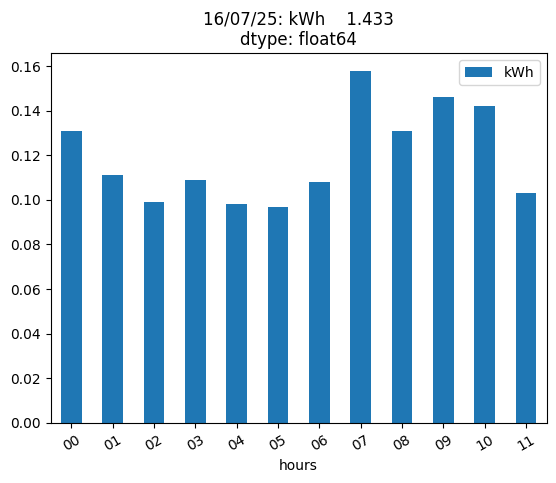

In [971]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [972]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'], dtype='object', name='hours')

# Conso du jour


In [973]:
grp_by_dayhours.count()

kWh       7534
cumsum    7534
diff      7219
days        12
dtype: int64

'27/01/25'

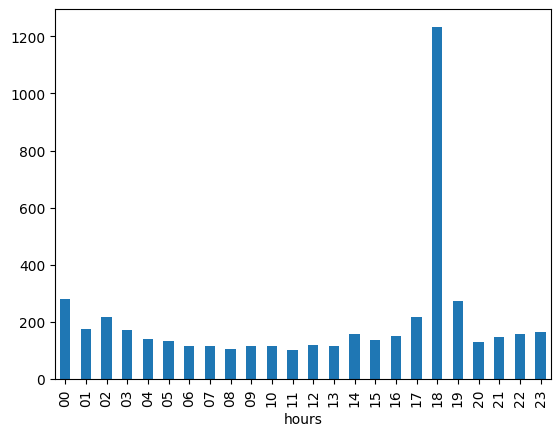

In [974]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [975]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 299.376 , Moyenne= 2.99376


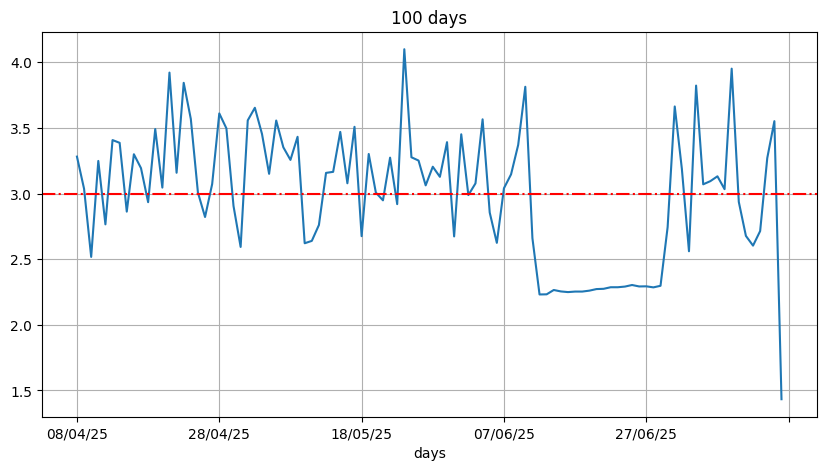

In [976]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [977]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 11:44:18, Minutes in day: 704


In [978]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [979]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:45.18


In [980]:
end - start

105.18378257751465

In [981]:
#df = conso_day
show_tranches()

2
2025-07-16 00:00:06.933106	2025-07-16 08:38:22.946106	8h 38m 16s 	1000
2025-07-16 08:38:22.946106	2025-07-16 11:42:40.915106	3h 4m 17s 	433


In [982]:
df_grp.tail(7)['kWh']

days
10/07/25    2.936
11/07/25    2.677
12/07/25    2.603
13/07/25    2.714
14/07/25    3.270
15/07/25    3.551
16/07/25    1.433
Name: kWh, dtype: float64

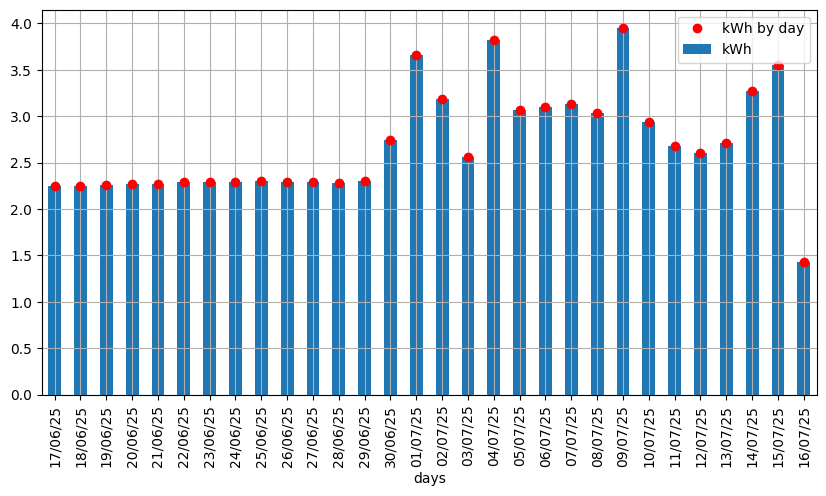

In [983]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

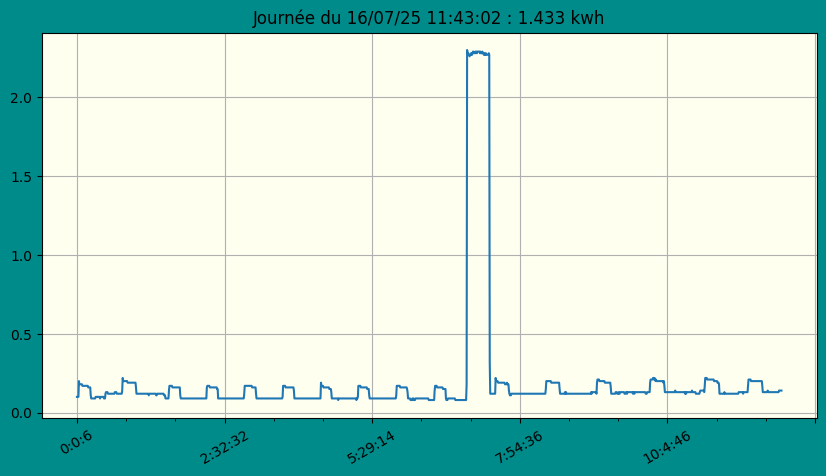

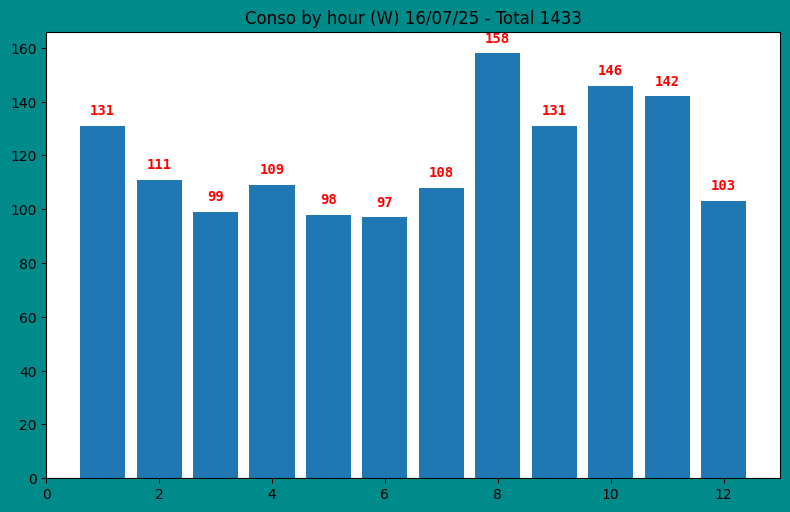

In [984]:
show(today,bgcolor='ivory')
conso_by_hour(today)

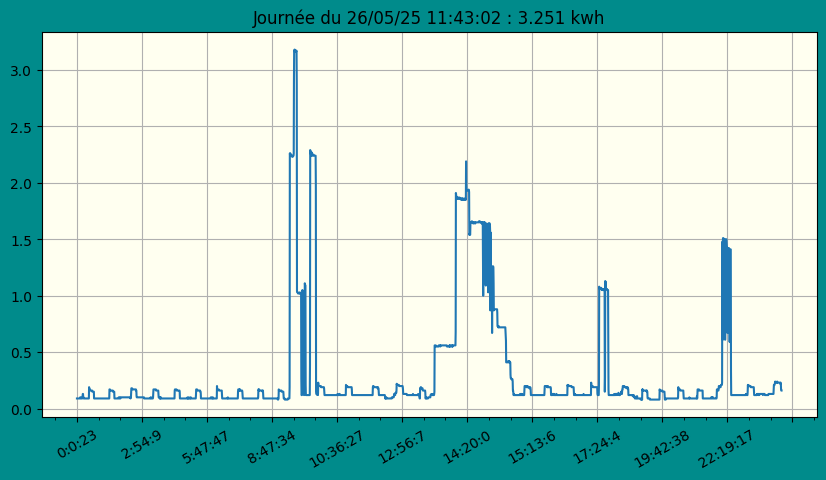

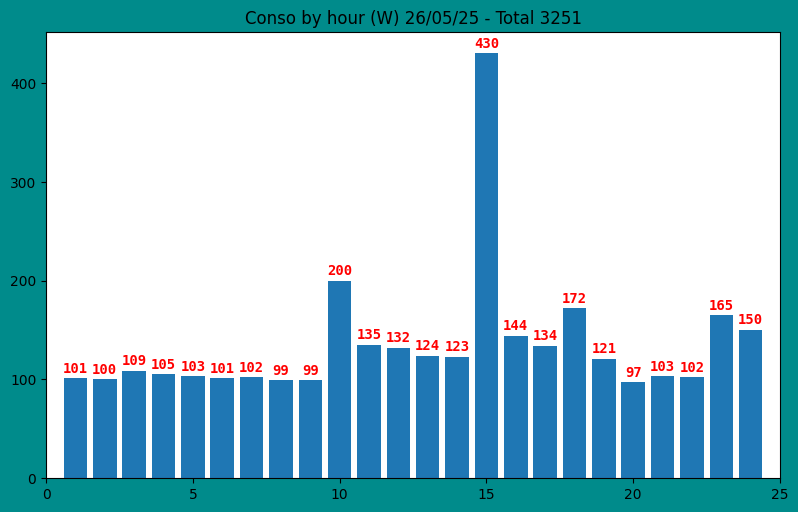

In [985]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4787)

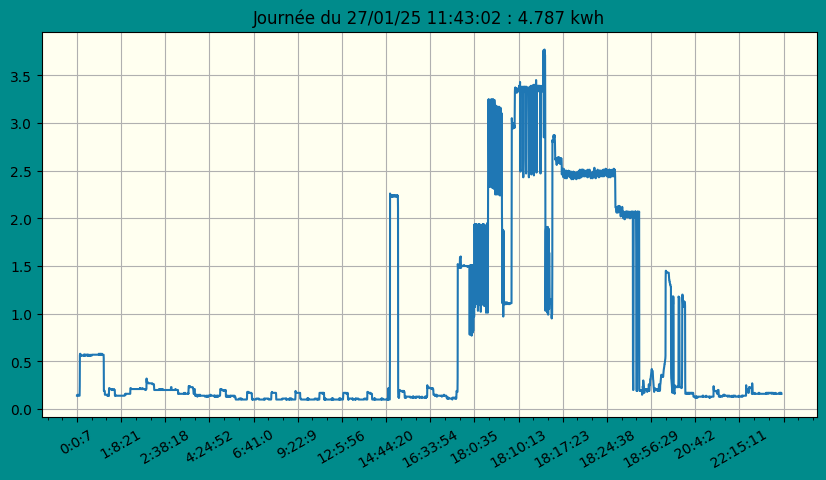

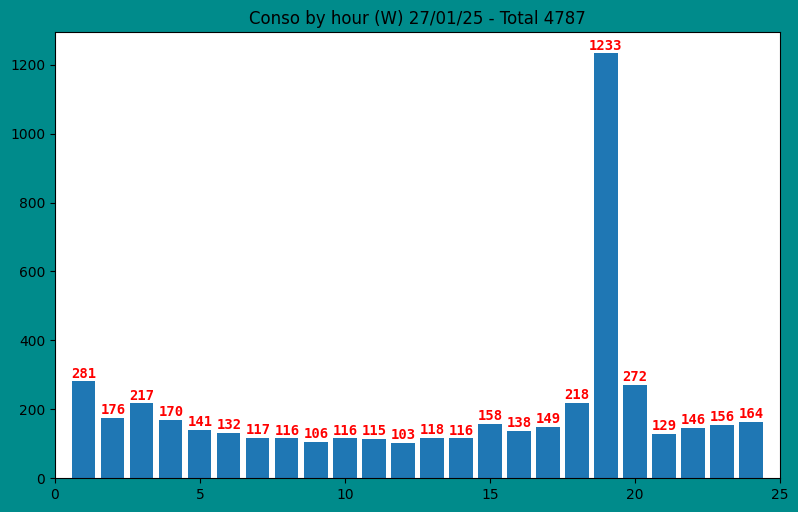

In [986]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

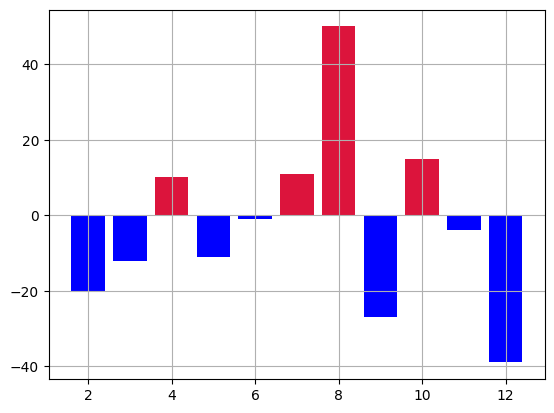

In [987]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

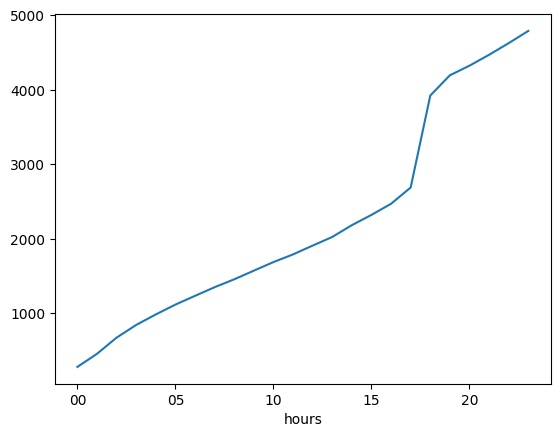

In [988]:
data.cumsum().plot()


<Axes: xlabel='hours'>

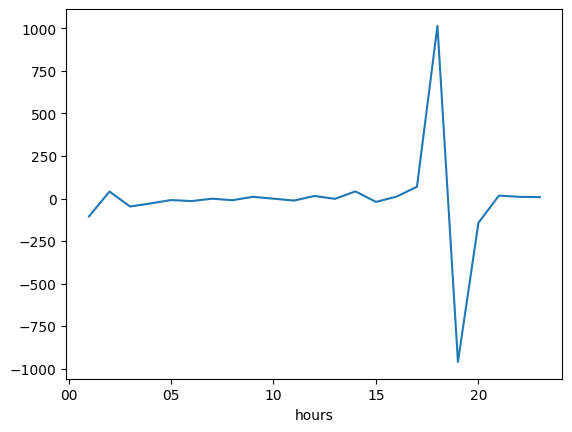

In [989]:
# evolution par heure
data.diff().plot()

In [990]:
data.diff().describe()

count      23.000000
mean       -5.086957
std       301.340628
min      -961.000000
25%       -17.500000
50%        -1.000000
75%        13.000000
max      1015.000000
Name: kWh, dtype: float64

<Axes: >

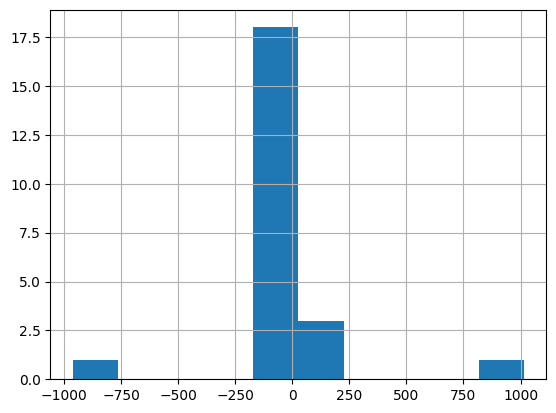

In [991]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [992]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [993]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

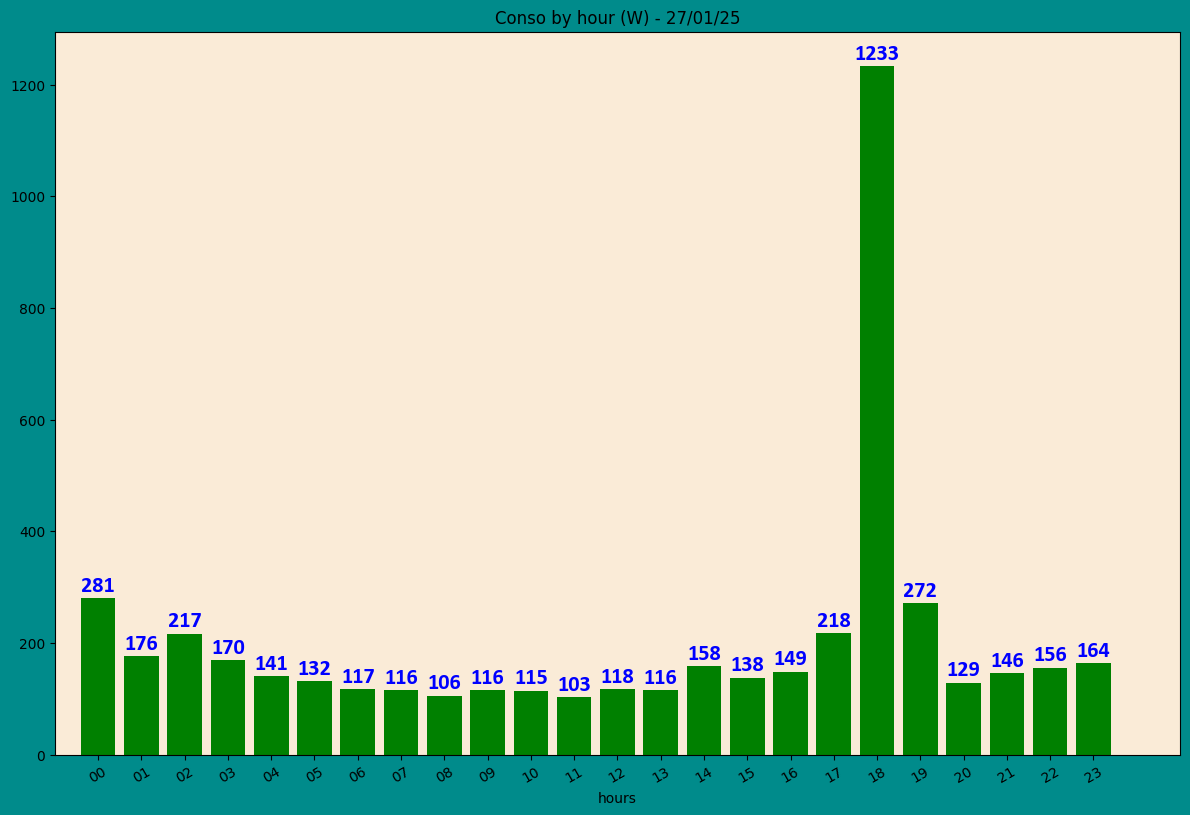

In [994]:
day,conso_byhour(day)

In [995]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


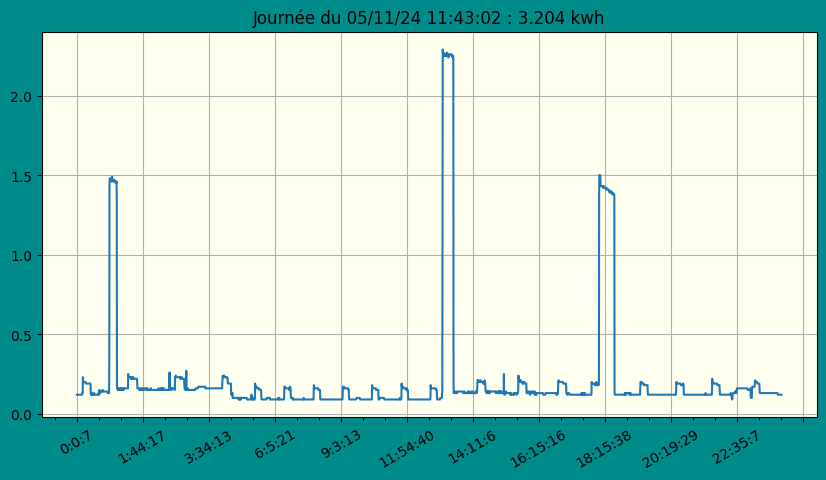

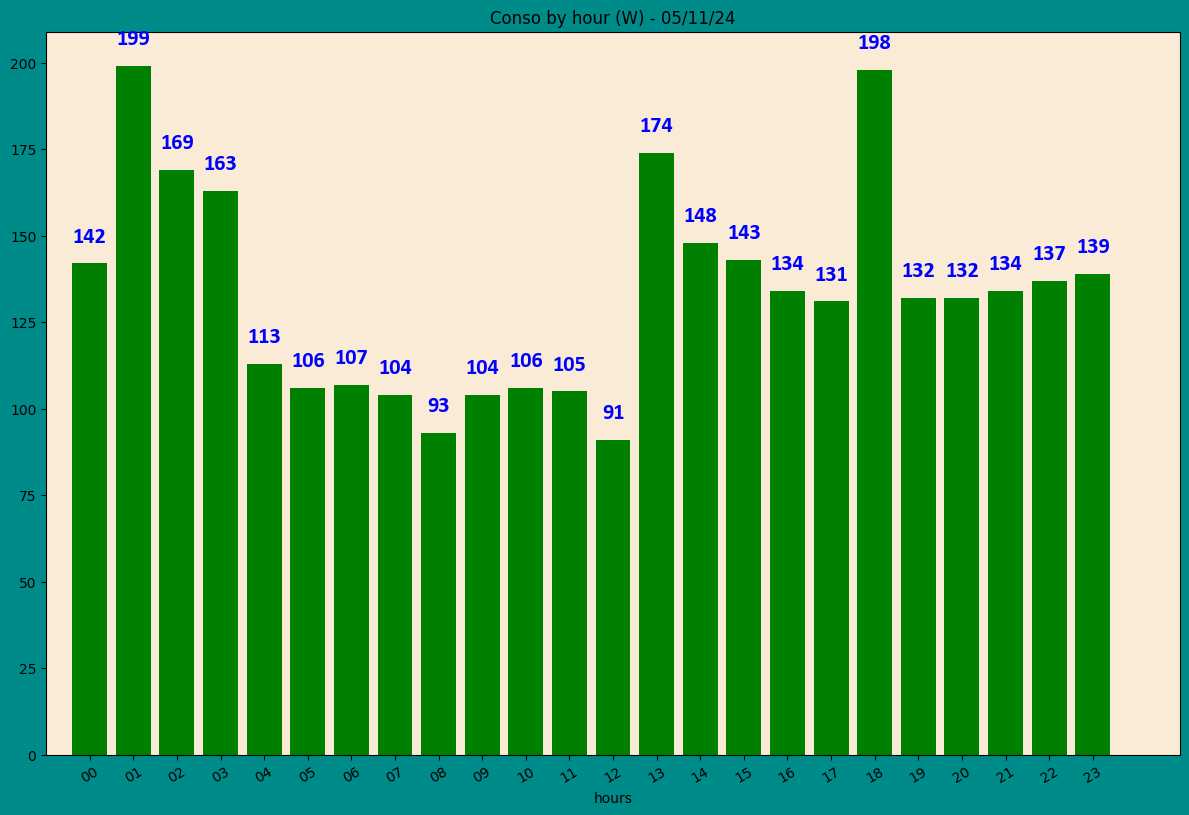

In [996]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [997]:
month

,day,hours,months,kWh
678478,01,00,2025-04,0.21
678479,01,00,2025-04,0.21
678480,01,00,2025-04,0.21
678481,01,00,2025-04,0.21
678482,01,00,2025-04,0.21
...,...,...,...,...
774484,30,23,2025-04,0.09
774485,30,23,2025-04,0.09
774486,30,23,2025-04,0.09
774487,30,23,2025-04,0.09


In [998]:
month.describe()


,kWh
count,96011.000000
mean,0.310190
std,0.547342
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

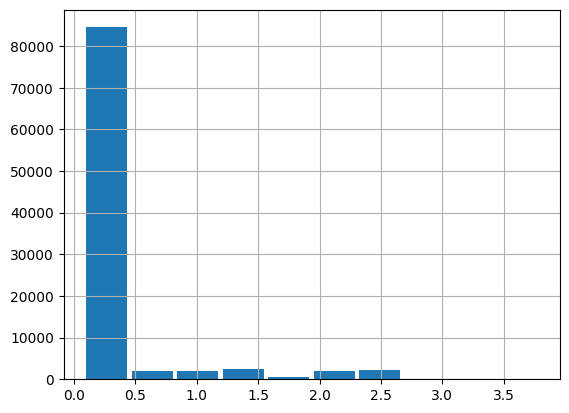

In [999]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

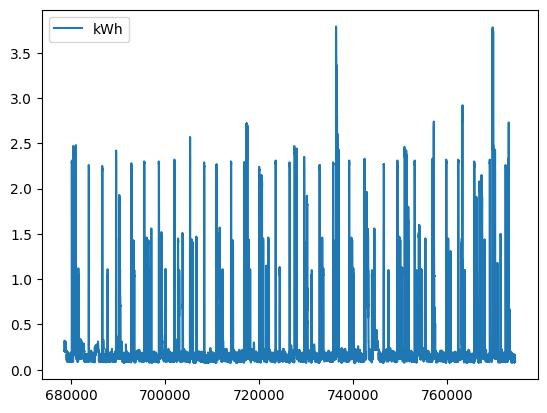

In [1000]:
month.plot()

In [1001]:
# index with max conso in this month
month.idxmax().kWh

np.int64(736348)

In [1002]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       771584
hours     682026
months    678478
kWh       736348
dtype: int64

In [1003]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1004]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
05/09/24 14      50      50    NaN   NaN
         15     162     212  112.0   NaN
         16     157     369   -5.0   NaN
         17     215     584   58.0   NaN
         18     161     745  -54.0   NaN
...             ...     ...    ...   ...
16/07/25 07     158     911   50.0   8.0
         08     131    1042  -27.0   9.0
         09     146    1188   15.0  10.0
         10     142    1330   -4.0  11.0
         11     103    1433  -39.0  12.0

[7534 rows x 4 columns]

In [1005]:
month

,day,hours,months,kWh
678478,01,00,2025-04,0.21
678479,01,00,2025-04,0.21
678480,01,00,2025-04,0.21
678481,01,00,2025-04,0.21
678482,01,00,2025-04,0.21
...,...,...,...,...
774484,30,23,2025-04,0.09
774485,30,23,2025-04,0.09
774486,30,23,2025-04,0.09
774487,30,23,2025-04,0.09


In [1006]:
month.idxmax()


day       771584
hours     682026
months    678478
kWh       736348
dtype: int64

In [1007]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 736348, dtype: object

In [1008]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       179
          01       175
          02       172
          03       121
          04       114
          05       110
          06       110
          07        99
          08       111
          09       110
          10       109
          11        98
          12       169
          13       144
          14       147
          15       134
          16       202
          17       142
          18       153
          19       192
          20       148
          21       146
          22       143
          23       174
Name: kWh, dtype: int64

In [1009]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

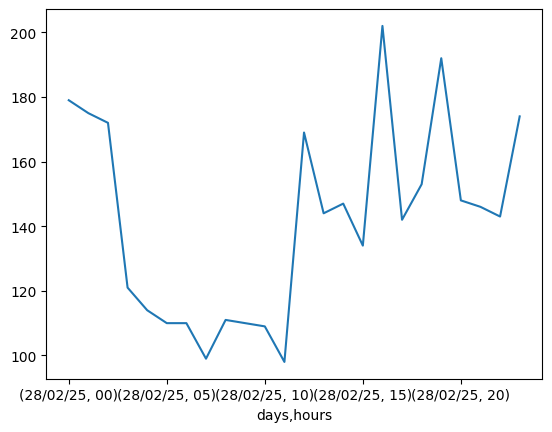

In [1010]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1011]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1012]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1013]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1014]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB